<a href="https://colab.research.google.com/github/yaeliavni/AI/blob/main/LAPD_OOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

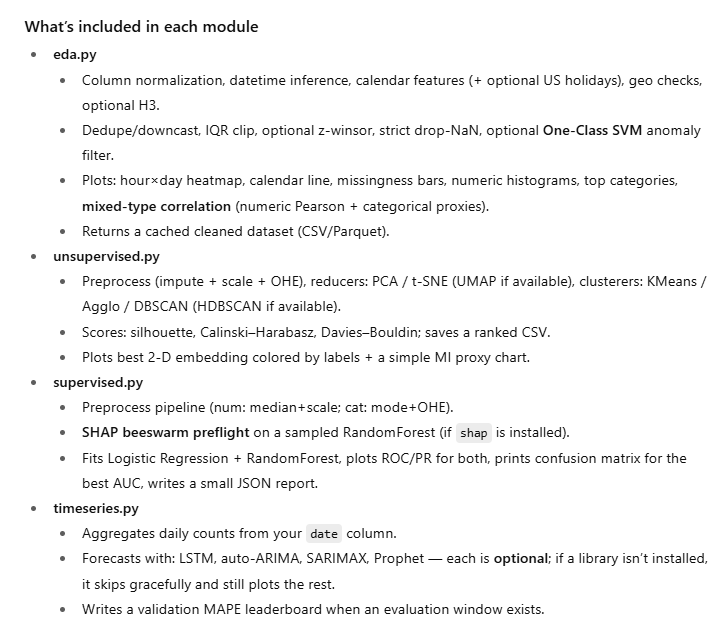

In [1]:
from eda import run_eda
from unsupervised import run_unsupervised
from supervised import run_supervised
from timeseries import run_timeseries



# EDA

[EDA Runner] Extracted CSV → /content/Crime_Data_from_2020_to_Present.csv
[EDA Runner] Reading full CSV once to derive ~5k stratified sample...
[EDA Runner] Full shape: (974477, 15)
[EDA Runner] Stratified sample using 'Area': 5,000 rows.
[EDA Runner] ✓ Wrote sample CSV → /content/Crime_Data_stratified_5k.csv

==== Running EDA on ~5k sample ====
==== [EDA-1] Read CSV/ZIP ====
shape: (5000, 15)
==== [EDA-2] Normalize column names ====
==== [EDA-3] Build datetime + add time features ====
preview time plots skipped: Grouper for 'hour' not 1-dimensional
==== [EDA-4] Geo cleanup ====
              issue  count
0  zero_zero_coords     15
1   outside_LA_bbox     15
==== [EDA-5] Dedupe & downcast ====
==== [EDA-6] Outliers (IQR clip + optional z-winsor) ====
==== [EDA-7] STRICT drop-any-NaN (after feature creation) ====
==== [EDA-8] Optional One-Class SVM outlier filter (post-clean) ====
==== [EDA-9] Rich EDA visuals ====
🖼️ saved: /content/figs_eda_5k/Missingness-—-cleaned.png


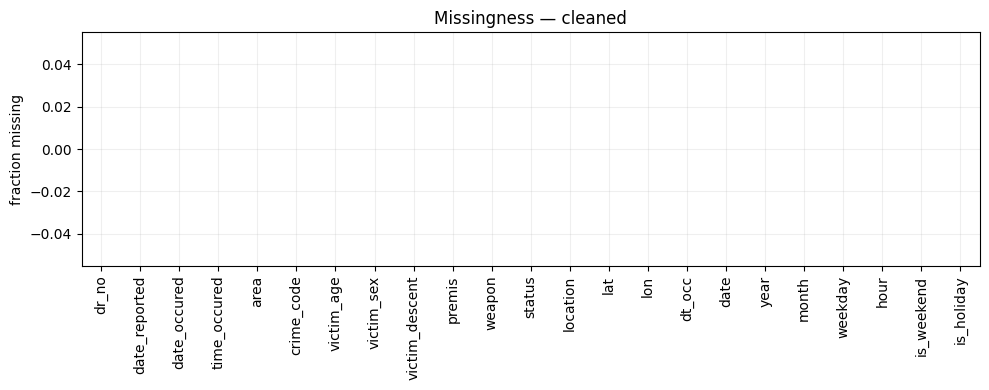

🖼️ saved: /content/figs_eda_5k/Numeric-Distributions-—-cleaned.png


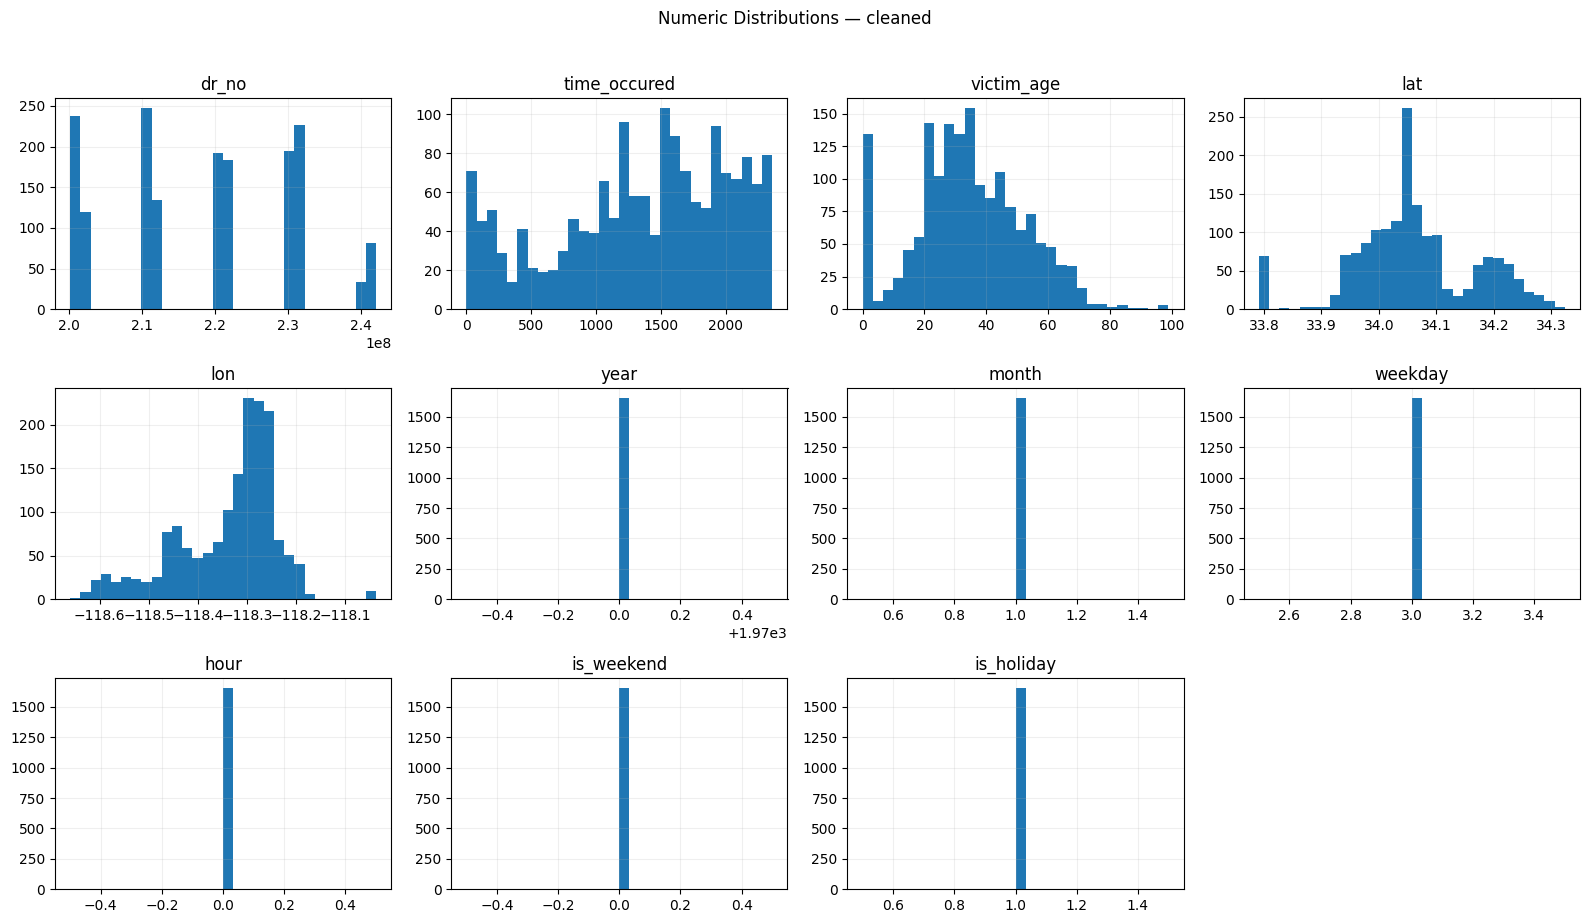

🖼️ saved: /content/figs_eda_5k/Mixed-correlations-(num-+-cat).png


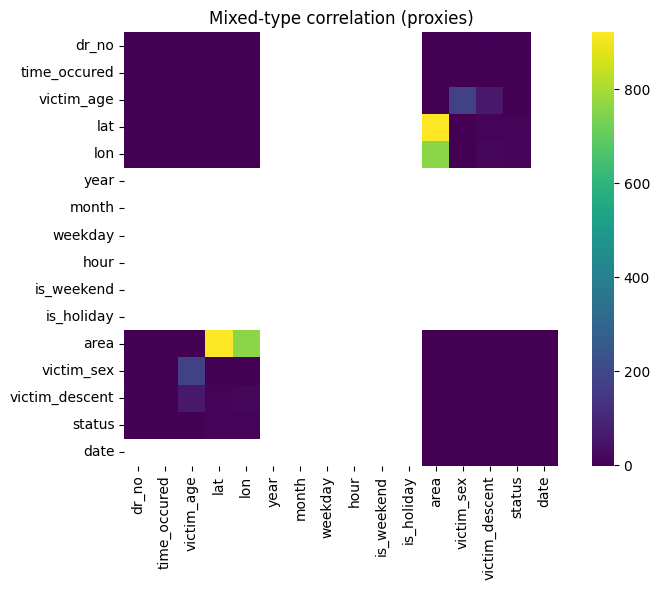

✓ Cleaned data saved to: /content/lapd_clean_5k.parquet

=== EDA DONE ===
EDA figs:        /content/figs_eda_5k
Cleaned dataset: /content/lapd_clean_5k.parquet


In [2]:
# === LAPD EDA-only runner on ~5k stratified sample (Colab-friendly) ==========
# Place this in one Colab cell and run it.
# Requires ONLY: eda.py (exposes: run_eda)
#
# What it does:
# 1) Resolve RAW_PATH (CSV or ZIP) → CSV
# 2) Read CSV once, pick a stratify column (Crm Cd / Crm Cd Desc / AREA NAME)
#    and create an ~5k stratified sample (fallback to random if needed)
# 3) Save sample to /content/Crime_Data_stratified_5k.csv
# 4) Call run_eda() ONLY on the sample and save outputs under /content
#
# Tweakables:
SAMPLE_SIZE   = 5000          # "about 5000" (StratifiedShuffleSplit may give +/- a few)
RAW_PATH      = "/content/Crime_Data_from_2020_to_Present.csv.zip"  # change if needed
OUT_DIR       = "/content"
EDA_FIGS      = f"{OUT_DIR}/figs_eda_5k"
SAMPLE_CSV    = f"{OUT_DIR}/Crime_Data_stratified_5k.csv"
CLEAN_PATH    = f"{OUT_DIR}/lapd_clean_5k.parquet"
RANDOM_STATE  = 42

# EDA config (safe/speedy defaults). Switch as you like.
EDA_CONFIG = {
    "add_h3": False,            # set True only if h3 is installed AND you want hex features
    "svms_outlier_clip": False, # off for speed on the 5k sample (toggle to True if you want)
    "preview_rows": 10000
}

# -----------------------------------------------------------------------------
import os, sys, zipfile, pandas as pd, numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# Make sure we can import local eda.py
if "" not in sys.path:
    sys.path.insert(0, "")
try:
    from eda import run_eda
except Exception as e:
    raise ImportError("Couldn't import run_eda from eda.py. Make sure eda.py is in the working directory.") from e

os.makedirs(EDA_FIGS, exist_ok=True)

def _resolve_raw_path(p: str, out_dir: str) -> str:
    """Accept CSV or ZIP. If ZIP, extract first CSV to out_dir and return its path."""
    if not os.path.exists(p):
        raise FileNotFoundError(f"Raw file not found: {p}")
    if p.lower().endswith(".zip") and zipfile.is_zipfile(p):
        with zipfile.ZipFile(p) as zf:
            csv_members = [m for m in zf.namelist() if m.lower().endswith(".csv")]
            if not csv_members:
                raise ValueError("ZIP found but contains no CSV.")
            target = csv_members[0]
            zf.extract(target, out_dir)
            extracted_csv = os.path.join(out_dir, os.path.basename(target))
            print(f"[EDA Runner] Extracted CSV → {extracted_csv}")
            return extracted_csv
    if p.lower().endswith(".zip") and not zipfile.is_zipfile(p):
        maybe_csv = p[:-4]
        if os.path.exists(maybe_csv):
            print(f"[EDA Runner] {p} is not a zip; using CSV next to it → {maybe_csv}")
            return maybe_csv
        raise ValueError(f"{p} is not a valid ZIP and {maybe_csv} not found.")
    return p  # assume CSV

def _pick_stratify_col(cols):
    """Pick a good stratification column by preference order."""
    candidates = [
        "Crm Cd", "Crm Cd Desc", "Crime Code", "Crime Code Description",
        "AREA NAME", "AREA", "Area Name", "Part 1-2"
    ]
    lower = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in lower:
            return lower[cand.lower()]
    return None

def _make_stratified_sample(df: pd.DataFrame, target_col: str, n: int, random_state: int) -> pd.DataFrame:
    """Use StratifiedShuffleSplit to select about n rows, preserving class proportions."""
    if n >= len(df):
        print(f"[EDA Runner] Requested sample size ({n}) >= dataset size ({len(df)}); using full data.")
        return df.copy()

    # Stratify targets (avoid NaNs)
    y = df[target_col].astype(str).fillna("__NA__")
    frac = n / len(df)
    # Cap fraction between (0,1)
    frac = max(min(frac, 0.9), 1e-6)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=frac, random_state=random_state)
    # sss.split expects X, y; we can pass indices as X
    for _, test_idx in sss.split(np.zeros(len(df)), y):
        sample = df.iloc[test_idx].copy()
        break

    # If we overshot, trim; if slightly under, it's fine
    if len(sample) > n:
        sample = sample.sample(n=n, random_state=random_state)
    print(f"[EDA Runner] Stratified sample using '{target_col}': {len(sample):,} rows.")
    return sample

def _make_random_sample(df: pd.DataFrame, n: int, random_state: int) -> pd.DataFrame:
    if n >= len(df):
        return df.copy()
    sample = df.sample(n=n, random_state=random_state)
    print(f"[EDA Runner] Random sample (fallback): {len(sample):,} rows.")
    return sample

# 1) Resolve raw path
raw_csv = _resolve_raw_path(RAW_PATH, OUT_DIR)

# 2) Read CSV once, pick stratify col, build ~5k sample
print("[EDA Runner] Reading full CSV once to derive ~5k stratified sample...")
df_full = pd.read_csv(raw_csv, low_memory=False)
print(f"[EDA Runner] Full shape: {df_full.shape}")

strat_col = _pick_stratify_col(df_full.columns)
if strat_col is not None:
    try:
        df_sample = _make_stratified_sample(df_full, strat_col, SAMPLE_SIZE, RANDOM_STATE)
    except Exception as e:
        print(f"[EDA Runner] Stratified sampling failed on '{strat_col}' → falling back to random. Reason: {e}")
        df_sample = _make_random_sample(df_full, SAMPLE_SIZE, RANDOM_STATE)
else:
    print("[EDA Runner] No suitable stratify column found → using random sample.")
    df_sample = _make_random_sample(df_full, SAMPLE_SIZE, RANDOM_STATE)

# Free memory from full DF sooner
del df_full

# 3) Save sample CSV (so run_eda can read it)
df_sample.to_csv(SAMPLE_CSV, index=False)
print(f"[EDA Runner] ✓ Wrote sample CSV → {SAMPLE_CSV}")

# 4) Run EDA ONLY on the sample
print("\n==== Running EDA on ~5k sample ====")
clean_path = run_eda(
    raw_csv_path=SAMPLE_CSV,
    fig_dir=EDA_FIGS,
    cache_path=CLEAN_PATH,
    config_overrides=EDA_CONFIG
)
print("\n=== EDA DONE ===")
print(f"EDA figs:        {EDA_FIGS}")
print(f"Cleaned dataset: {clean_path}")


#Supervised

In [ ]:
# === Supervised (clean, fast, SHAP-free) on the EDA cleaned ~5k sample ========
# Uses /content/lapd_clean_5k.parquet (or CSV fallback) produced by your EDA cell.
# Outputs under /content/figs_sup_5k

import os, sys, json, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier

warnings.filterwarnings("ignore")

# --------------------------------- CONFIG -------------------------------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"  # change if you saved CSV instead
OUT_DIR      = "/content/figs_sup_5k"
RANDOM_STATE = 42
TEST_SIZE    = 0.25

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------- load cleaned sample ---------------------------------
def _load_clean_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_clean_df(CLEAN_PATH)
print(f"[Supervised] Loaded cleaned sample: {df.shape}")

# -------------------- pick a usable target automatically -----------------------
# Rules:
# - candidate if: non-numeric ID-like columns excluded, unique classes between 2 and 10
# - balance: minority class >= 5% (for binary) or no class < 3% (for multiclass)
# - prefer binary; otherwise smallest-classes multiclass
EXCLUDE_REGEX = (
    "date|time|lat|lon|h3|x_|y_|geohash|id$|^id|addr|location|coord|month|day|hour"
)
exclude_cols = [
    c for c in df.columns
    if pd.Series([c]).str.contains(EXCLUDE_REGEX, case=False, regex=True).iloc[0]
]

# Drop fully constant columns
constant_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
usable_cols = [c for c in df.columns if c not in exclude_cols and c not in constant_cols]

def _good_target(col: pd.Series):
    vc = col.value_counts(dropna=False)
    # cannot be numeric continuous with too many uniques
    if col.dtype.kind in "iuf" and vc.size > 15:
        return False
    # must have at least 2 classes
    if vc.size < 2:
        return False
    # max classes 10 to keep things light
    if vc.size > 10:
        return False
    # balance checks
    n = len(col)
    freqs = vc.values / n
    if vc.size == 2:
        return freqs.min() >= 0.05
    else:
        return (freqs >= 0.03).all()

# strong preferred names if present
PREFERRED = [
    "Part 1-2", "Part_1_2", "Part1_2", "Crm Cd", "Crm Cd Desc",
    "Crime Code", "Crime Code Description", "AREA NAME", "ARREST MADE",
    "Status", "Status Desc"
]
pref = [c for c in PREFERRED if c in usable_cols and _good_target(df[c])]

candidates = pref or [c for c in usable_cols if _good_target(df[c])]
if not candidates:
    # last resort: discretize a numeric column into bins
    num_cols = [c for c in usable_cols if pd.api.types.is_numeric_dtype(df[c])]
    if not num_cols:
        raise RuntimeError("No suitable target candidate found and no numeric columns to discretize.")
    tgt = num_cols[0]
    df["__TARGET__"] = pd.qcut(df[tgt], q=3, labels=["low","mid","high"])
    target_col = "__TARGET__"
else:
    # prefer binary candidates
    bin_cands = [c for c in candidates if df[c].nunique(dropna=False) == 2]
    target_col = (bin_cands or candidates)[0]

print(f"[Supervised] Target selected: {target_col} (classes={df[target_col].nunique(dropna=False)})")

# ------------------------- build X / y and encode ------------------------------
y = df[target_col].astype("category")
X = df.drop(columns=[target_col]).copy()

# Remove columns that are now useless or leakage-like (IDs we missed)
X = X.drop(columns=[c for c in X.columns if c in exclude_cols or c in constant_cols], errors="ignore")

# Basic sanitization
for c in X.select_dtypes(include=["bool"]).columns:
    X[c] = X[c].astype(int)

# Keep only columns with at least 2 distinct non-null values
X = X[[c for c in X.columns if X[c].dropna().nunique() >= 2]]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# ------------------------------ pick model -------------------------------------
is_binary = y.nunique() == 2
if is_binary:
    model = LogisticRegression(max_iter=200, n_jobs=None, class_weight="balanced", random_state=RANDOM_STATE)
else:
    model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

pipe = Pipeline([("pre", pre), ("clf", model)])

# ------------------------------ split & fit ------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)

pipe.fit(X_train, y_train)

# ------------------------------ evaluate ---------------------------------------
y_pred = pipe.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
with open(os.path.join(OUT_DIR, "classification_report.json"), "w") as f:
    json.dump(report, f, indent=2)

print("[Supervised] Classification report (micro summary):")
print(json.dumps({k: report[k] for k in report if k in ["accuracy","macro avg","weighted avg"]}, indent=2))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
fig = plt.figure(figsize=(5,4))
plt.imshow(cm, aspect="auto")
plt.xticks(range(len(y.cat.categories)), y.cat.categories, rotation=45, ha="right")
plt.yticks(range(len(y.cat.categories)), y.cat.categories)
plt.title(f"Confusion Matrix — target: {target_col}")
plt.colorbar()
plt.tight_layout()
cm_path = os.path.join(OUT_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=160)
plt.close()
print(f"[Supervised] Saved: {cm_path}")

# ROC (binary only)
if is_binary:
    try:
        # get positive class probabilities
        proba = pipe.predict_proba(X_test)[:, list(pipe.classes_).index(y.cat.categories[1])]
        auc = roc_auc_score((y_test == y.cat.categories[1]).astype(int), proba)
        fpr, tpr, _ = roc_curve((y_test == y.cat.categories[1]).astype(int), proba)
        fig = plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
        plt.plot([0,1], [0,1], linestyle="--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
        plt.legend()
        roc_path = os.path.join(OUT_DIR, "roc_curve.png")
        plt.tight_layout(); plt.savefig(roc_path, dpi=160); plt.close()
        print(f"[Supervised] Saved: {roc_path}")
    except Exception as e:
        print(f"[Supervised] ROC skipped: {e}")

# ----------------------- lightweight "feature importance" ----------------------
# For logistic regression, report top absolute coefficients (after OHE).
# For HGB, use feature_importances_ via permutation-like surrogate if absent.
def _feature_names(preprocessor, X_fit):
    pre = preprocessor
    names = []
    if hasattr(pre, "transformers_"):
        for name, trans, cols in pre.transformers_:
            if name == "drop":
                continue
            if hasattr(trans, "get_feature_names_out"):
                try:
                    names.extend(list(trans.get_feature_names_out(cols)))
                except:
                    names.extend(list(cols))
            else:
                names.extend(list(cols))
    else:
        names = list(X_fit.columns)
    return names

feat_names = _feature_names(pipe.named_steps["pre"], X_train)

importance = None
clf = pipe.named_steps["clf"]
try:
    if is_binary and hasattr(clf, "coef_"):
        coefs = np.abs(clf.coef_[0])
        importance = pd.DataFrame({"feature": feat_names, "importance": coefs}).sort_values("importance", ascending=False)
    elif hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        importance = pd.DataFrame({"feature": feat_names, "importance": imps}).sort_values("importance", ascending=False)
except Exception as e:
    print(f"[Supervised] Importance extraction skipped: {e}")

if importance is not None:
    topk = importance.head(25)
    topk.to_csv(os.path.join(OUT_DIR, "feature_importance_top25.csv"), index=False)
    fig = plt.figure(figsize=(6, max(4, len(topk)*0.3)))
    plt.barh(topk["feature"][::-1], topk["importance"][::-1])
    plt.title("Top features")
    plt.tight_layout()
    imp_path = os.path.join(OUT_DIR, "feature_importance_top25.png")
    plt.savefig(imp_path, dpi=160); plt.close()
    print(f"[Supervised] Saved: {imp_path}")

print("\n=== Supervised (compact) DONE ===")
print(f"Figures & reports → {OUT_DIR}")


[Supervised] Loaded cleaned sample: (1651, 23)
[Supervised] Target selected: victim_sex (classes=3)
[Supervised] Classification report (micro summary):
{
  "accuracy": 0.6368038740920097,
  "macro avg": {
    "precision": 0.7297187854880164,
    "recall": 0.7285377650450068,
    "f1-score": 0.7285887039408167,
    "support": 413.0
  },
  "weighted avg": {
    "precision": 0.6359997238745608,
    "recall": 0.6368038740920097,
    "f1-score": 0.6356455373225486,
    "support": 413.0
  }
}
[Supervised] Saved: /content/figs_sup_5k/confusion_matrix.png

=== Supervised (compact) DONE ===
Figures & reports → /content/figs_sup_5k


In [ ]:
# === Supervised: robust multi-model compare + plots (handles XGB label needs) ==
import os, json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

warnings.filterwarnings("ignore")

CLEAN_PATH = "/content/lapd_clean_5k.parquet"    # cleaned file from EDA step
OUT_DIR    = "/content/figs_sup_5k_models"
TARGET     = "victim_sex"                         # from your results
TEST_SIZE  = 0.25
RANDOM_SEED= 42

os.makedirs(OUT_DIR, exist_ok=True)

# --- load
if os.path.exists(CLEAN_PATH) and CLEAN_PATH.lower().endswith(".parquet"):
    df = pd.read_parquet(CLEAN_PATH)
else:
    alt = os.path.splitext(CLEAN_PATH)[0] + ".csv"
    df = pd.read_csv(alt, low_memory=False)

assert TARGET in df.columns, f"Target '{TARGET}' not found in dataframe."

y = df[TARGET].astype("category")
X = df.drop(columns=[TARGET]).copy()

# prune degenerate columns
const_cols = [c for c in X.columns if X[c].dropna().nunique() <= 1]
if const_cols:
    X = X.drop(columns=const_cols)

# bool -> int; keep only columns with ≥2 distinct values
for c in X.select_dtypes(include=["bool"]).columns:
    X[c] = X[c].astype(int)
X = X[[c for c in X.columns if X[c].dropna().nunique() >= 2]]

num_cols = [c for c in X.columns if pd.api.types.is_numeric_dtype(X[c])]
cat_cols = [c for c in X.columns if not pd.api.types.is_numeric_dtype(X[c])]

# OneHotEncoder API compatibility: sklearn>=1.2 uses sparse_output
def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=False)

pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_cols),
        ("cat", _make_ohe(), cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

# split once → shared across models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y
)

# fit transform to arrays
pre.fit(X_train)
XT_train = pre.transform(X_train)
XT_test  = pre.transform(X_test)

# helper for feature names (for importances later if needed)
def _feature_names(preprocessor, X_fit):
    names = []
    for name, trans, cols in preprocessor.transformers_:
        if name == "drop":
            continue
        if hasattr(trans, "get_feature_names_out"):
            try:
                names.extend(list(trans.get_feature_names_out(cols)))
            except:
                names.extend(list(cols))
        else:
            names.extend(list(cols))
    return names
feat_names = _feature_names(pre, X_train)

# --- models
models = {}
models["LogReg"] = LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=None, random_state=RANDOM_SEED)
models["RF"]     = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
models["HGB"]    = HistGradientBoostingClassifier(random_state=RANDOM_SEED)

# optional XGB (label-encode y)
has_xgb = True
try:
    from xgboost import XGBClassifier
    models["XGB"] = XGBClassifier(
        eval_metric="mlogloss", use_label_encoder=False, random_state=RANDOM_SEED
    )
except Exception as _:
    has_xgb = False
    print("[Info] xgboost not available; skipping XGB.")

# Train/eval
metrics = []
cms = {}
reports = {}

# Prepare y for XGB (numeric)
le = LabelEncoder().fit(y_train)  # maps classes to [0..k-1]
y_train_num = le.transform(y_train)
y_test_num  = le.transform(y_test)

for name, clf in models.items():
    if name == "XGB":
        # XGB requires numeric labels
        clf.fit(XT_train, y_train_num)
        y_pred_num = clf.predict(XT_test)
        y_pred = le.inverse_transform(y_pred_num)
    else:
        clf.fit(XT_train, y_train)
        y_pred = clf.predict(XT_test)

    acc = accuracy_score(y_test, y_pred)
    f1m = f1_score(y_test, y_pred, average="macro")
    metrics.append({"model": name, "accuracy": acc, "macro_f1": f1m})

    cm  = confusion_matrix(y_test, y_pred, labels=y.cat.categories)
    cms[name] = cm
    reports[name] = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

# Save tabular metrics
res_df = pd.DataFrame(metrics).sort_values("macro_f1", ascending=False)
res_df.to_csv(os.path.join(OUT_DIR, "model_comparison.csv"), index=False)
print(res_df)

# Plot bar chart
fig, ax = plt.subplots(figsize=(6,4))
res_df.set_index("model")[["accuracy","macro_f1"]].plot.bar(ax=ax)
plt.title(f"Model Comparison — {TARGET}")
plt.ylabel("Score")
plt.ylim(0,1)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "model_comparison.png"), dpi=150)
plt.close()
print(f"[Saved] {OUT_DIR}/model_comparison.png")

# Save individual confusion matrices
labels = list(y.cat.categories)
for name, cm in cms.items():
    fig = plt.figure(figsize=(4.2,3.6))
    plt.imshow(cm, aspect="auto")
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(f"Confusion — {name}")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    path = os.path.join(OUT_DIR, f"cm_{name}.png")
    plt.savefig(path, dpi=150); plt.close()
    print(f"[Saved] {path}")

# Side-by-side confusion matrices for top-2 models (by macro_f1)
top2 = list(res_df["model"].head(2))
if len(top2) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(8.8, 3.8), sharex=True, sharey=True)
    for i, name in enumerate(top2):
        ax = axes[i]
        cm = cms[name]
        im = ax.imshow(cm, aspect="auto")
        ax.set_title(f"{name}")
        ax.set_xticks(range(len(labels))); ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticks(range(len(labels))); ax.set_yticklabels(labels)
    fig.suptitle(f"Confusion matrices (Top-2 by macro F1) — {TARGET}")
    fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
    plt.tight_layout(rect=[0,0,1,0.95])
    path = os.path.join(OUT_DIR, "cm_top2_side_by_side.png")
    plt.savefig(path, dpi=150); plt.close()
    print(f"[Saved] {path}")

# Save detailed reports
with open(os.path.join(OUT_DIR, "classification_reports.json"), "w") as f:
    json.dump(reports, f, indent=2)

print("\n=== Supervised model comparison complete ===")
print(f"Outputs in: {OUT_DIR}")


    model  accuracy  macro_f1
1      RF  0.651332  0.733391
2     HGB  0.627119  0.727652
3     XGB  0.631961  0.724019
0  LogReg  0.237288  0.200611
[Saved] /content/figs_sup_5k_models/model_comparison.png
[Saved] /content/figs_sup_5k_models/cm_LogReg.png
[Saved] /content/figs_sup_5k_models/cm_RF.png
[Saved] /content/figs_sup_5k_models/cm_HGB.png
[Saved] /content/figs_sup_5k_models/cm_XGB.png
[Saved] /content/figs_sup_5k_models/cm_top2_side_by_side.png

=== Supervised model comparison complete ===
Outputs in: /content/figs_sup_5k_models


#Unsupervised

# attempts

In [ ]:
# === Unsupervised runner (fast, Colab-friendly, ~5k cleaned sample) ===========
# Inputs:  /content/lapd_clean_5k.parquet  (created by your EDA cell)
# Outputs: /content/figs_unsup_5k/*

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

warnings.filterwarnings("ignore")

# ------------------------------- CONFIG ---------------------------------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"   # fallback to CSV if missing
OUT_DIR      = "/content/figs_unsup_5k"
RANDOM_STATE = 42

# Feature building
MAX_CAT_CARD = 30      # only one-hot categoricals with ≤ 30 categories
SVD_COMPONENTS = 50    # compact space for clustering & TSNE/UMAP
TSNE_PERPLEX  = 30

os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------- LOAD -----------------------------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UNSUP] Loaded cleaned sample: {df.shape}")

# -------------------------- BUILD FEATURE MATRIX ------------------------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Drop super-constant cols (avoid zero-variance)
constant_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
df = df.drop(columns=constant_cols)

# Choose features: numeric + low-cardinality categoricals
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_cols_all = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
# keep only cats with <= MAX_CAT_CARD unique non-null
cat_cols = [c for c in cat_cols_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid obvious labels/leakage-like columns if they exist
DROP_LIKE = {"victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
             "Crime Code Description","ARREST MADE","Status","Status Desc"}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]

Xdf = df[use_cols].copy()
# sanitize: bool->int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UNSUP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ----------------------- DIMENSIONALITY REDUCTION -----------------------------
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1)), random_state=RANDOM_STATE)
X_svd = svd.fit_transform(X_sparse)
print(f"[UNSUP] SVD space: {X_svd.shape}, explained_var_sum≈{svd.explained_variance_ratio_.sum():.2f}")

# PCA-like 2D via SVD→2
svd2 = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
X_2d_svd = svd2.fit_transform(X_sparse)

# UMAP (optional)
has_umap = True
try:
    import umap
    um = umap.UMAP(n_components=2, n_neighbors=30, min_dist=0.1, random_state=RANDOM_STATE)
    X_2d_umap = um.fit_transform(X_sparse)
except Exception as _:
    has_umap = False
    X_2d_umap = None
    print("[UNSUP] UMAP unavailable; skipping.")

# t-SNE on dense SVD (fix: avoid PCA init on sparse)
from sklearn.manifold import TSNE
tsne_in = X_svd  # already dense, 50-D
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEX, learning_rate="auto",
            init="random", random_state=RANDOM_STATE, n_iter=800, verbose=0)
X_2d_tsne = tsne.fit_transform(tsne_in)

# ----------------------------- CLUSTERING -------------------------------------
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
metrics = []
labels_dict = {}

# Evaluate helpers
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X, y):
    # handle weird cases (all same label or noise only)
    if len(set(y)) <= 1 or (len(set(y))==1 and list(set(y))[0]==-1):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try:
        sil = silhouette_score(X, y)
    except Exception:
        sil = np.nan
    try:
        ch  = calinski_harabasz_score(X, y)
    except Exception:
        ch = np.nan
    try:
        db  = davies_bouldin_score(X, y)
    except Exception:
        db = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len(set(y)) - (1 if -1 in set(y) else 0))

# Try KMeans (k=2..8) on 50-D SVD
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"KMeans","config":f"k={k}", **sc})
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# Agglomerative (Ward) on 50-D SVD for k in 2..6
best_ag = None
for k in range(2, 7):
    ag = AgglomerativeClustering(n_clusters=k, linkage="ward")
    lab = ag.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"Agglomerative","config":f"k={k}", **sc})
    labels_dict[("Agglomerative", f"k={k}")] = lab
    if best_ag is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_ag[0], nan=-9)):
        best_ag = (sc["silhouette"], ("Agglomerative", f"k={k}"))

# DBSCAN on 50-D SVD (couple of eps/min_samples combos)
db_configs = [(0.8,10), (1.0,10), (1.2,10)]
for eps, ms in db_configs:
    db = DBSCAN(eps=eps, min_samples=ms, n_jobs=-1)
    lab = db.fit_predict(X_svd)
    sc = _scores(X_svd, lab)
    metrics.append({"algo":"DBSCAN","config":f"eps={eps},min={ms}", **sc})
    labels_dict[("DBSCAN", f"eps={eps},min={ms}")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for min_c in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=min_c)
        lab = hb.fit_predict(X_svd)
        sc = _scores(X_svd, lab)
        metrics.append({"algo":"HDBSCAN","config":f"min_size={min_c}", **sc})
        labels_dict[("HDBSCAN", f"min_size={min_c}")] = lab
except Exception:
    has_hdb = False
    print("[UNSUP] HDBSCAN unavailable; skipping.")

res_df = pd.DataFrame(metrics).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10))
print(f"[UNSUP] Saved results → {res_csv}")

# Pick best by silhouette
best_row = res_df.iloc[0]
best_key = (best_row["algo"], best_row["config"])
best_labels = labels_dict[best_key]

# Save labels (row-aligned)
lab_path = os.path.join(OUT_DIR, "cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UNSUP] Saved labels → {lab_path}  ({best_key})")

# ----------------------------- PLOTTING ---------------------------------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    # color by cluster; noise (-1) gets gray
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.6)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UNSUP] Saved: {path}")

# Best labels on each embedding
_scatter_targets = [
    ("SVD2", X_2d_svd),
    ("UMAP2", X_2d_umap) if has_umap else None,
    ("tSNE2", X_2d_tsne),
]
for tag in _scatter_targets:
    if tag is None:
        continue
    name, X2 = tag
    _scatter(X2, best_labels, f"{name} — {best_key[0]} ({best_key[1]})", os.path.join(OUT_DIR, f"Best_{name}.png"))

# Also: per‑algo best on SVD2 for quick scan
def _best_for_algo(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","Agglomerative","DBSCAN","HDBSCAN"]:
    key = _best_for_algo(algo)
    if key and key in labels_dict:
        _scatter(X_2d_svd, labels_dict[key], f"SVD2 — {key[0]} ({key[1]})", os.path.join(OUT_DIR, f"SVD2_{algo}_best.png"))

# ---------------------- Quick NMI vs known columns ----------------------------
from sklearn.metrics import normalized_mutual_info_score

probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        y_c = df[c].astype(str).fillna("__NA__")
        nmi = normalized_mutual_info_score(y_c, best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    nmi_df = pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)
    nmi_df.to_csv(os.path.join(OUT_DIR, "cluster_alignment_NMI.csv"), index=False)
    print("[UNSUP] Cluster alignment (NMI):")
    print(nmi_df)
else:
    print("[UNSUP] No probe columns found for NMI (AREA NAME / Part 1-2 / Crm Cd Desc).")

print("\n=== Unsupervised complete ===")
print(f"Figures → {OUT_DIR}")


[UNSUP] Loaded cleaned sample: (1651, 23)
[UNSUP] Feature matrix: shape=(1651, 38), sparse=True
[UNSUP] SVD space: (1651, 37), explained_var_sum≈1.00
            algo config  silhouette          ch        db  n_clusters
7  Agglomerative    k=2    0.234699  405.055917  1.657256           2
0         KMeans    k=2    0.230698  416.375699  1.688367           2
3         KMeans    k=5    0.152045  265.249883  1.742082           5
1         KMeans    k=3    0.151473  340.551932  2.071401           3
4         KMeans    k=6    0.148029  242.423776  1.896650           6
2         KMeans    k=4    0.147117  306.181240  1.874744           4
9  Agglomerative    k=4    0.137582  237.038895  1.946703           4
6         KMeans    k=8    0.134555  205.552828  1.902078           8
5         KMeans    k=7    0.132146  222.746327  1.965363           7
8  Agglomerative    k=3    0.128479  290.674694  2.082787           3
[UNSUP] Saved results → /content/figs_unsup_5k/unsup_results.csv
[UNSUP] Saved l

In [ ]:
# === Unsupervised (UMAP-focused) runner — Colab-ready =========================
# Input  : /content/lapd_clean_5k.parquet   (CSV fallback supported)
# Outputs: /content/figs_unsup_umap_5k/*

import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_unsup_umap_5k"
RANDOM_STATE = 42

# feature build
MAX_CAT_CARD = 30        # only one-hot categoricals with <=30 unique values
USE_SVD_BEFORE_UMAP = True  # speeds UMAP on wide sparse matrices
SVD_COMPONENTS = 50
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST   = 0.10

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UMAP] Loaded cleaned sample: {df.shape}")

# drop constant cols
constant = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if constant:
    df = df.drop(columns=constant)

# ---------------- FEATURES --------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid leakagey columns (adjust as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool -> int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(),               [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UMAP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ---------------- UMAP EMBEDDING --------
# install umap-learn if missing
try:
    import umap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
    import umap

# (optional) SVD pre-step for speed
if USE_SVD_BEFORE_UMAP:
    from sklearn.decomposition import TruncatedSVD
    svd = TruncatedSVD(n_components=min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1)),
                       random_state=RANDOM_STATE)
    X_for_umap = svd.fit_transform(X_sparse)
    umap_metric = "euclidean"
    print(f"[UMAP] Using SVD{X_for_umap.shape[1]} → UMAP (metric={umap_metric})")
else:
    X_for_umap = X_sparse      # UMAP can work on CSR
    umap_metric = "euclidean"  # or "cosine" for text-like sparse

um = umap.UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric=umap_metric,
    random_state=RANDOM_STATE,
    verbose=False,
)
X_umap2 = um.fit_transform(X_for_umap)
print(f"[UMAP] 2D embedding shape: {X_umap2.shape}")

# ---------------- CLUSTERING ------------
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X2, y):
    # invalid: 1 or fewer clusters (after excluding noise)
    uniq = set(y)
    if len(uniq) <= 1 or (len(uniq)==1 and (-1 in uniq)):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try: sil = silhouette_score(X2, y)
    except: sil = np.nan
    try: ch  = calinski_harabasz_score(X2, y)
    except: ch  = np.nan
    try: db  = davies_bouldin_score(X2, y)
    except: db  = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len([u for u in uniq if u!=-1]))

labels_dict, rows = {}, []

# KMeans k=2..8
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    rows.append({"algo":"KMeans","config":f"k={k}", **sc})
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# DBSCAN (light sweep)
for eps in (0.3, 0.5, 0.7):
    db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
    lab = db.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    rows.append({"algo":"DBSCAN","config":f"eps={eps},min=10", **sc})
    labels_dict[("DBSCAN", f"eps={eps},min=10")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for mcs in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=mcs)
        lab = hb.fit_predict(X_umap2)
        sc = _scores(X_umap2, lab)
        rows.append({"algo":"HDBSCAN","config":f"min_size={mcs}", **sc})
        labels_dict[("HDBSCAN", f"min_size={mcs}")] = lab
except Exception:
    has_hdb = False
    print("[UMAP] HDBSCAN unavailable; skipping.")

res_df = pd.DataFrame(rows).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "umap_unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10))
print(f"[UMAP] Saved results → {res_csv}")

# choose best by silhouette
best = res_df.iloc[0]
best_key = (best["algo"], best["config"])
best_labels = labels_dict[best_key]

# save labels aligned to rows
lab_path = os.path.join(OUT_DIR, "umap_cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UMAP] Saved labels → {lab_path}  ({best_key})")

# ---------------- PLOTS -----------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.5)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UMAP] Saved: {path}")

_scatter(X_umap2, best_labels,
         f"UMAP2 — {best_key[0]} ({best_key[1]})",
         os.path.join(OUT_DIR, "Best_UMAP2.png"))

# per-algo best on UMAP2
def _best_for(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","DBSCAN","HDBSCAN"]:
    key = _best_for(algo)
    if key and key in labels_dict:
        _scatter(X_umap2, labels_dict[key],
                 f"UMAP2 — {key[0]} ({key[1]})",
                 os.path.join(OUT_DIR, f"UMAP2_{algo}_best.png"))

# quick metric bar for KMeans sweep
km_rows = res_df[res_df["algo"]=="KMeans"].copy()
if len(km_rows):
    plt.figure(figsize=(6,4))
    x = [r.split("=")[1] for r in km_rows["config"]]
    plt.bar(x, km_rows["silhouette"].fillna(0))
    plt.title("KMeans on UMAP2 — silhouette by k")
    plt.xlabel("k"); plt.ylabel("silhouette")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "KMeans_silhouette_by_k.png"), dpi=150); plt.close()
    print("[UMAP] Saved: KMeans_silhouette_by_k.png")

# ---------------- Alignment to known columns (optional) -----------------------
from sklearn.metrics import normalized_mutual_info_score
probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        nmi = normalized_mutual_info_score(df[c].astype(str).fillna("__NA__"), best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)\
      .to_csv(os.path.join(OUT_DIR, "umap_cluster_alignment_NMI.csv"), index=False)
    print("[UMAP] Saved: umap_cluster_alignment_NMI.csv")

print("\n=== UMAP Unsupervised complete ===")
print(f"Figures & CSVs → {OUT_DIR}")


[UMAP] Loaded cleaned sample: (1651, 23)
[UMAP] Feature matrix: shape=(1651, 38), sparse=True
[UMAP] Using SVD37 → UMAP (metric=euclidean)
[UMAP] 2D embedding shape: (1651, 2)
       algo          config  silhouette           ch        db  n_clusters
0    KMeans             k=2    0.584391  2160.484619  0.481288           2
11  HDBSCAN     min_size=20    0.566980  2087.459473  0.411640           3
6    KMeans             k=8    0.559578  4615.204590  0.618558           8
1    KMeans             k=3    0.549134  2796.414551  0.648065           3
3    KMeans             k=5    0.539478  3819.672119  0.616038           5
5    KMeans             k=7    0.539388  4394.787598  0.658795           7
4    KMeans             k=6    0.536366  4011.421387  0.616063           6
8    DBSCAN  eps=0.5,min=10    0.517858  2913.423340  0.519936           5
2    KMeans             k=4    0.514911  3251.586670  0.719669           4
7    DBSCAN  eps=0.3,min=10    0.468276  2561.550537  1.495330          12

In [ ]:
# === Unsupervised (UMAP-focused) runner — with UMAP metadata in results =======
# Input  : /content/lapd_clean_5k.parquet   (CSV fallback supported)
# Outputs: /content/figs_unsup_umap_5k/*
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# ---------------- CONFIG ----------------
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_unsup_umap_5k"
RANDOM_STATE = 42

# feature build
MAX_CAT_CARD = 30        # only one-hot categoricals with <=30 unique values
USE_SVD_BEFORE_UMAP = True  # speeds UMAP on wide sparse matrices
SVD_COMPONENTS = 50
UMAP_N_NEIGHBORS = 30
UMAP_MIN_DIST   = 0.10

os.makedirs(OUT_DIR, exist_ok=True)

# ---------------- LOAD ------------------
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            return pd.read_parquet(path)
        return pd.read_csv(path, low_memory=False)
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        return pd.read_csv(alt, low_memory=False)
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

df = _load_df(CLEAN_PATH)
print(f"[UMAP] Loaded cleaned sample: {df.shape}")

# drop constant cols
constant = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if constant:
    df = df.drop(columns=constant)

# ---------------- FEATURES --------------
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# avoid leakagey columns (adjust as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc","Crime Code",
    "Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool -> int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

def _make_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(),               [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[UMAP] Feature matrix: shape={X_sparse.shape}, sparse={hasattr(X_sparse,'tocsr')}")

# ---------------- UMAP EMBEDDING --------
# install umap-learn if missing
try:
    import umap
except Exception:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
    import umap

# (optional) SVD pre-step for speed
actual_svd_components = None
if USE_SVD_BEFORE_UMAP:
    from sklearn.decomposition import TruncatedSVD
    actual_svd_components = min(SVD_COMPONENTS, max(2, X_sparse.shape[1]-1))
    svd = TruncatedSVD(n_components=actual_svd_components, random_state=RANDOM_STATE)
    X_for_umap = svd.fit_transform(X_sparse)
    umap_metric = "euclidean"
    print(f"[UMAP] Using SVD{X_for_umap.shape[1]} → UMAP (metric={umap_metric})")
else:
    X_for_umap = X_sparse      # UMAP can work on CSR
    umap_metric = "euclidean"  # or "cosine" for text-like sparse

um = umap.UMAP(
    n_components=2,
    n_neighbors=UMAP_N_NEIGHBORS,
    min_dist=UMAP_MIN_DIST,
    metric=umap_metric,
    random_state=RANDOM_STATE,
    verbose=False,
)
X_umap2 = um.fit_transform(X_for_umap)
print(f"[UMAP] 2D embedding shape: {X_umap2.shape}")

# ---------------- CLUSTERING ------------
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def _scores(X2, y):
    # invalid: 1 or fewer clusters (after excluding noise)
    uniq = set(y)
    if len(uniq) <= 1 or (len(uniq)==1 and (-1 in uniq)):
        return dict(silhouette=np.nan, ch=np.nan, db=np.nan, n_clusters=1)
    try: sil = silhouette_score(X2, y)
    except: sil = np.nan
    try: ch  = calinski_harabasz_score(X2, y)
    except: ch  = np.nan
    try: db  = davies_bouldin_score(X2, y)
    except: db  = np.nan
    return dict(silhouette=sil, ch=ch, db=db, n_clusters=len([u for u in uniq if u!=-1]))

labels_dict, rows = {}, []

# helper to append with UMAP metadata
def _append_result(algo, config, score_dict):
    meta = {
        "embedding": "UMAP2",
        "umap_metric": umap_metric,
        "umap_n_neighbors": UMAP_N_NEIGHBORS,
        "umap_min_dist": UMAP_MIN_DIST,
        "use_svd_before_umap": bool(USE_SVD_BEFORE_UMAP),
        "svd_components": int(actual_svd_components) if actual_svd_components is not None else None,
    }
    rows.append({"algo": algo, "config": config, **score_dict, **meta})

# KMeans k=2..8
best_km = None
for k in range(2, 9):
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    lab = km.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    _append_result("KMeans", f"k={k}", sc)
    labels_dict[("KMeans", f"k={k}")] = lab
    if best_km is None or (np.nan_to_num(sc["silhouette"], nan=-9) > np.nan_to_num(best_km[0], nan=-9)):
        best_km = (sc["silhouette"], ("KMeans", f"k={k}"))

# DBSCAN (light sweep)
for eps in (0.3, 0.5, 0.7):
    db = DBSCAN(eps=eps, min_samples=10, n_jobs=-1)
    lab = db.fit_predict(X_umap2)
    sc = _scores(X_umap2, lab)
    _append_result("DBSCAN", f"eps={eps},min=10", sc)
    labels_dict[("DBSCAN", f"eps={eps},min=10")] = lab

# HDBSCAN (optional)
has_hdb = True
try:
    import hdbscan
    for mcs in (10, 20):
        hb = hdbscan.HDBSCAN(min_cluster_size=mcs)
        lab = hb.fit_predict(X_umap2)
        sc = _scores(X_umap2, lab)
        _append_result("HDBSCAN", f"min_size={mcs}", sc)
        labels_dict[("HDBSCAN", f"min_size={mcs}")] = lab
except Exception:
    has_hdb = False
    print("[UMAP] HDBSCAN unavailable; skipping.")

# results table WITH UMAP columns
res_df = pd.DataFrame(rows).sort_values(["silhouette","ch"], ascending=[False, False])
res_csv = os.path.join(OUT_DIR, "umap_unsup_results.csv")
res_df.to_csv(res_csv, index=False)
print(res_df.head(10)[["embedding","algo","config","silhouette","ch","db","n_clusters",
                       "umap_metric","umap_n_neighbors","umap_min_dist","use_svd_before_umap","svd_components"]])
print(f"[UMAP] Saved results → {res_csv}")

# choose best by silhouette
best = res_df.iloc[0]
best_key = (best["algo"], best["config"])
best_labels = labels_dict[best_key]

# save labels aligned to rows
lab_path = os.path.join(OUT_DIR, "umap_cluster_labels.csv")
pd.DataFrame({"cluster": best_labels}).to_csv(lab_path, index=False)
print(f"[UMAP] Saved labels → {lab_path}  ({best_key})")

# ---------------- PLOTS -----------------
def _scatter(X2, y, title, path):
    plt.figure(figsize=(6,5))
    uniq = sorted(set(y))
    colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u!=-1]))))
    cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u!=-1])}
    cmap[-1] = (0.6,0.6,0.6,0.5)
    for u in uniq:
        m = (y==u)
        plt.scatter(X2[m,0], X2[m,1], s=10, c=[cmap[u]], label=str(u))
    plt.legend(title="cluster", ncol=4, fontsize=8, markerscale=2)
    plt.title(title); plt.tight_layout(); plt.savefig(path, dpi=150); plt.close()
    print(f"[UMAP] Saved: {path}")

_scatter(X_umap2, best_labels,
         f"UMAP2 — {best_key[0]} ({best_key[1]})",
         os.path.join(OUT_DIR, "Best_UMAP2.png"))

# per-algo best on UMAP2
def _best_for(algo):
    sub = res_df[res_df["algo"]==algo]
    return tuple(sub.iloc[0][["algo","config"]]) if len(sub) else None

for algo in ["KMeans","DBSCAN","HDBSCAN"]:
    key = _best_for(algo)
    if key and key in labels_dict:
        _scatter(X_umap2, labels_dict[key],
                 f"UMAP2 — {key[0]} ({key[1]})",
                 os.path.join(OUT_DIR, f"UMAP2_{algo}_best.png"))

# quick metric bar for KMeans sweep
km_rows = res_df[res_df["algo"]=="KMeans"].copy()
if len(km_rows):
    plt.figure(figsize=(6,4))
    x = [r.split("=")[1] for r in km_rows["config"]]
    plt.bar(x, km_rows["silhouette"].fillna(0))
    plt.title("KMeans on UMAP2 — silhouette by k")
    plt.xlabel("k"); plt.ylabel("silhouette")
    plt.tight_layout(); plt.savefig(os.path.join(OUT_DIR, "KMeans_silhouette_by_k.png"), dpi=150); plt.close()
    print("[UMAP] Saved: KMeans_silhouette_by_k.png")

# ---------------- Alignment to known columns (optional) -----------------------
from sklearn.metrics import normalized_mutual_info_score
probe_cols = [c for c in ["AREA NAME","Part 1-2","Crm Cd Desc","AREA","Part 1_2"] if c in df.columns]
if probe_cols:
    nmi_rows = []
    for c in probe_cols:
        nmi = normalized_mutual_info_score(df[c].astype(str).fillna("__NA__"), best_labels)
        nmi_rows.append({"column": c, "NMI": float(nmi)})
    pd.DataFrame(nmi_rows).sort_values("NMI", ascending=False)\
      .to_csv(os.path.join(OUT_DIR, "umap_cluster_alignment_NMI.csv"), index=False)
    print("[UMAP] Saved: umap_cluster_alignment_NMI.csv")

print("\n=== UMAP Unsupervised complete ===")
print(f"Figures & CSVs → {OUT_DIR}")


[UMAP] Loaded cleaned sample: (1651, 23)
[UMAP] Feature matrix: shape=(1651, 38), sparse=True
[UMAP] Using SVD37 → UMAP (metric=euclidean)
[UMAP] 2D embedding shape: (1651, 2)
   embedding     algo          config  silhouette           ch        db  \
0      UMAP2   KMeans             k=2    0.584391  2160.484619  0.481288   
11     UMAP2  HDBSCAN     min_size=20    0.566980  2087.459473  0.411640   
6      UMAP2   KMeans             k=8    0.559578  4615.204590  0.618558   
1      UMAP2   KMeans             k=3    0.549134  2796.414551  0.648065   
3      UMAP2   KMeans             k=5    0.539478  3819.672119  0.616038   
5      UMAP2   KMeans             k=7    0.539388  4394.787598  0.658795   
4      UMAP2   KMeans             k=6    0.536366  4011.421387  0.616063   
8      UMAP2   DBSCAN  eps=0.5,min=10    0.517858  2913.423340  0.519936   
2      UMAP2   KMeans             k=4    0.514911  3251.586670  0.719669   
7      UMAP2   DBSCAN  eps=0.3,min=10    0.468276  2561.550537  

#final

In [3]:
# === Comprehensive Unsupervised Analysis (Dims 2–8 for PCA/UMAP/t‑SNE) ===
# Input  : /content/lapd_clean_5k.parquet  (CSV fallback supported)
# Output : /content/figs_comprehensive_unsup  (CSVs + best-plot if 2D)
# Author : streamlined per user request

import os, sys, warnings, time
from pathlib import Path
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# ============================================================================ #
# CONFIG
# ============================================================================ #
CLEAN_PATH   = "/content/lapd_clean_5k.parquet"
OUT_DIR      = "/content/figs_comprehensive_unsup"
RANDOM_STATE = 42
SILHOUETTE_THRESHOLD = 0.6

# Feature engineering
MAX_CAT_CARD   = 30
SVD_COMPONENTS = 50

# Embedding params
PCA_DIMS  = list(range(2, 9))        # 2..8
UMAP_DIMS = list(range(2, 9))        # 2..8
TSNE_DIMS = list(range(2, 9))        # 2..8

# A compact UMAP grid (kept small to avoid explosion)
UMAP_CONFIGS = [
    {"n_neighbors": 15, "min_dist": 0.1},
    {"n_neighbors": 30, "min_dist": 0.1},
]

# t‑SNE perplexities (validated per dataset size at run time)
TSNE_PERPLEXITY = [15, 30]

# "Other" methods — single, reasonable 2D configs to keep runtime sane
KPCA_CONFIG     = {"kernel": "rbf", "gamma": 0.1}
LLE_CONFIG      = {"n_neighbors": 20, "method": "standard"}
ISOMAP_NEIGHBORS= 20
MDS_METRIC      = True
FA_NCOMP        = 2
ICA_NCOMP       = 2

# Clustering parameters
KMEANS_K_RANGE = range(2, 12)
DBSCAN_CONFIGS = [
    {"eps": 0.3, "min_samples": 10},
    {"eps": 0.5, "min_samples": 10},
    {"eps": 0.7, "min_samples": 10},
]
HDBSCAN_CONFIGS = [{"min_cluster_size": 10}, {"min_cluster_size": 20}]

os.makedirs(OUT_DIR, exist_ok=True)

# ============================================================================ #
# UTILS
# ============================================================================ #
def _load_df(path: str) -> pd.DataFrame:
    if os.path.exists(path):
        if path.lower().endswith(".parquet"):
            df = pd.read_parquet(path)
        else:
            df = pd.read_csv(path, low_memory=False)
        print(f"[LOAD] {path} → shape={df.shape}")
        return df
    alt = os.path.splitext(path)[0] + ".csv"
    if os.path.exists(alt):
        df = pd.read_csv(alt, low_memory=False)
        print(f"[LOAD] {alt} → shape={df.shape}")
        return df
    raise FileNotFoundError(f"Cleaned data not found at {path} (or {alt}).")

def _scores(X, y):
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    uniq = set(y)
    if len(uniq) <= 1 or (uniq == {-1}):
        return {"silhouette": np.nan, "calinski_harabasz": np.nan, "davies_bouldin": np.nan,
                "n_clusters": 1, "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}
    try: sil = silhouette_score(X, y)
    except: sil = np.nan
    try: ch = calinski_harabasz_score(X, y)
    except: ch = np.nan
    try: db = davies_bouldin_score(X, y)
    except: db = np.nan
    return {"silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db,
            "n_clusters": len([u for u in uniq if u != -1]),
            "n_noise": int(np.sum(y == -1)) if -1 in uniq else 0}

def _make_ohe():
    from sklearn.preprocessing import OneHotEncoder
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

def timer(fn):
    def wrap(*a, **k):
        t0 = time.time()
        out = fn(*a, **k)
        print(f"[TIME] {fn.__name__}: {time.time()-t0:.2f}s")
        return out
    return wrap

# ============================================================================ #
# LOAD + PREPROCESS
# ============================================================================ #
print("="*58)
print("CREATING EMBEDDINGS")
print("="*58)

df = _load_df(CLEAN_PATH)

# Drop constants
const_cols = [c for c in df.columns if df[c].dropna().nunique() <= 1]
if const_cols:
    print(f"[CLEAN] Dropping constant columns: {const_cols}")
    df = df.drop(columns=const_cols)

# Feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
cat_all  = [c for c in df.columns if not pd.api.types.is_numeric_dtype(df[c])]
cat_cols = [c for c in cat_all if df[c].dropna().nunique() <= MAX_CAT_CARD]

# Avoid leakage-like columns (edit as needed)
DROP_LIKE = {
    "victim_sex","victim_age","Part 1-2","Crm Cd","Crm Cd Desc",
    "Crime Code","Crime Code Description","ARREST MADE","Status","Status Desc"
}
use_cols = [c for c in (num_cols + cat_cols) if c not in DROP_LIKE]
Xdf = df[use_cols].copy()

# bool→int
for c in Xdf.select_dtypes(include=["bool"]).columns:
    Xdf[c] = Xdf[c].astype(int)

pre = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False),
         [c for c in Xdf.columns if pd.api.types.is_numeric_dtype(Xdf[c])]),
        ("cat", _make_ohe(), [c for c in Xdf.columns if not pd.api.types.is_numeric_dtype(Xdf[c])]),
    ],
    remainder="drop",
)

X_sparse = pre.fit_transform(Xdf)
print(f"[PREPROCESS] Matrix: {X_sparse.shape} (sparse={hasattr(X_sparse,'tocsr')})")

embeddings = {}
results    = []

# ============================================================================ #
# BASELINE SVD (for stability + as UMAP/tSNE input)
# ============================================================================ #
@timer
def create_svd():
    from sklearn.decomposition import TruncatedSVD
    comp50 = min(SVD_COMPONENTS, X_sparse.shape[1]-1) if X_sparse.shape[1] > 1 else 1
    svd50  = TruncatedSVD(n_components=comp50, random_state=RANDOM_STATE)
    X50    = svd50.fit_transform(X_sparse)
    embeddings["SVD50"] = X50
    svd2   = TruncatedSVD(n_components=2, random_state=RANDOM_STATE)
    X2     = svd2.fit_transform(X_sparse)
    embeddings["SVD2"]  = X2
    print(f"[SVD] SVD50: {X50.shape} (expl.var≈{svd50.explained_variance_ratio_.sum():.3f})")
    print(f"[SVD] SVD2  : {X2.shape}  (expl.var≈{svd2.explained_variance_ratio_.sum():.3f})")

create_svd()

# ============================================================================ #
# PCA (dims 2..8)
# ============================================================================ #
@timer
def create_pca():
    from sklearn.decomposition import PCA, IncrementalPCA
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse
    for d in PCA_DIMS:
        if d >= min(X_dense.shape):
            continue
        if getattr(X_dense, "nbytes", 0) > 1_200_000_000:
            pca = IncrementalPCA(n_components=d, batch_size=1000)
        else:
            pca = PCA(n_components=d, random_state=RANDOM_STATE)
        Xp = pca.fit_transform(X_dense)
        embeddings[f"PCA{d}"] = Xp
        ev = getattr(pca, "explained_variance_ratio_", None)
        msg = f" (expl.var≈{ev.sum():.3f})" if ev is not None else ""
        print(f"[PCA] PCA{d}: {Xp.shape}{msg}")

create_pca()

# ============================================================================ #
# UMAP (dims 2..8), using SVD50 input for efficiency
# ============================================================================ #
@timer
def create_umap():
    try:
        import umap
    except ImportError:
        import subprocess
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "umap-learn"], check=True)
        import umap
    Xin = embeddings["SVD50"]
    for d in UMAP_DIMS:
        for cfg in UMAP_CONFIGS:
            key = f"UMAP{d}_n{cfg['n_neighbors']}_d{cfg['min_dist']}"
            try:
                um = umap.UMAP(n_components=d, metric="euclidean",
                               random_state=RANDOM_STATE, verbose=False, **cfg)
                Xu = um.fit_transform(Xin)
                embeddings[key] = Xu
                print(f"[UMAP] {key}: {Xu.shape}")
            except Exception as e:
                print(f"[UMAP][FAIL] {key}: {e}")

create_umap()

# ============================================================================ #
# t-SNE (dims 2..8), switch to method="exact" for d >= 4 (fixes BH limitation)
# ============================================================================ #
@timer
def create_tsne():
    from sklearn.manifold import TSNE
    Xin = embeddings["SVD50"]
    n = Xin.shape[0]
    max_perp = min(50, (n - 1) / 3.0)
    perps = [p for p in TSNE_PERPLEXITY if p <= max_perp]
    if not perps:
        perps = [min(30, max(5, int(max_perp)))]
    for d in TSNE_DIMS:
        method = "barnes_hut" if d <= 3 else "exact"
        for p in perps:
            key = f"tSNE{d}_p{p}_m{method[:1]}"
            try:
                ts = TSNE(n_components=d, perplexity=p, learning_rate="auto",
                          init="random", random_state=RANDOM_STATE,
                          n_iter=1000, method=method, verbose=0)
                Xt = ts.fit_transform(Xin)
                embeddings[key] = Xt
                print(f"[tSNE] {key}: {Xt.shape}")
            except Exception as e:
                print(f"[tSNE][FAIL] {key}: {e}")

create_tsne()

# ============================================================================ #
# “Other” methods — single 2D configs (compact)
# ============================================================================ #
@timer
def create_other_methods():
    # Kernel PCA (2D on a sample if large)
    from sklearn.decomposition import KernelPCA, FactorAnalysis, FastICA, TruncatedSVD
    from sklearn.manifold import LocallyLinearEmbedding, Isomap, MDS

    # Dense view when needed
    X_dense = X_sparse.toarray() if hasattr(X_sparse, "toarray") else X_sparse

    # Sampling for heavy methods
    sample_size = min(2000, X_sparse.shape[0])
    sample_idx  = None
    if sample_size < X_sparse.shape[0]:
        rng = np.random.RandomState(RANDOM_STATE)
        sample_idx = rng.choice(X_sparse.shape[0], sample_size, replace=False)
        X_sample = X_dense[sample_idx] if hasattr(X_dense, "__getitem__") else X_dense
        print(f"[SAMPLE] Using sample of {sample_size} for heavy methods")
    else:
        X_sample = X_dense

    # KPCA (2D)
    try:
        kp = KernelPCA(n_components=2, random_state=RANDOM_STATE, **KPCA_CONFIG)
        Xk = kp.fit_transform(X_sample)
        embeddings["KPCA2"] = Xk
        if sample_idx is not None: embeddings["KPCA2_sample_idx"] = sample_idx
        print(f"[KPCA] KPCA2: {Xk.shape}")
    except Exception as e:
        print(f"[KPCA][FAIL] {e}")

    # LLE (2D)
    try:
        lle = LocallyLinearEmbedding(n_components=2, random_state=RANDOM_STATE, **LLE_CONFIG)
        Xl = lle.fit_transform(X_sample)
        embeddings["LLE2"] = Xl
        if sample_idx is not None: embeddings["LLE2_sample_idx"] = sample_idx
        print(f"[LLE] LLE2: {Xl.shape}")
    except Exception as e:
        print(f"[LLE][FAIL] {e}")

    # Isomap (2D)
    try:
        iso = Isomap(n_components=2, n_neighbors=ISOMAP_NEIGHBORS, n_jobs=-1)
        Xi = iso.fit_transform(X_sample)
        embeddings["Isomap2"] = Xi
        if sample_idx is not None: embeddings["Isomap2_sample_idx"] = sample_idx
        print(f"[Isomap] Isomap2: {Xi.shape}")
    except Exception as e:
        print(f"[Isomap][FAIL] {e}")

    # MDS (2D)
    try:
        mds = MDS(n_components=2, random_state=RANDOM_STATE, n_jobs=-1, metric=MDS_METRIC)
        Xm = mds.fit_transform(X_sample)
        embeddings["MDS2"] = Xm
        if sample_idx is not None: embeddings["MDS2_sample_idx"] = sample_idx
        print(f"[MDS] MDS2: {Xm.shape}")
    except Exception as e:
        print(f"[MDS][FAIL] {e}")

    # Factor Analysis (2D)
    try:
        fa = FactorAnalysis(n_components=FA_NCOMP, random_state=RANDOM_STATE)
        Xfa = fa.fit_transform(X_dense)
        embeddings["FA2"] = Xfa
        print(f"[FA] FA2: {Xfa.shape}")
    except Exception as e:
        print(f"[FA][FAIL] {e}")

    # ICA (2D)
    try:
        ica = FastICA(n_components=ICA_NCOMP, random_state=RANDOM_STATE, max_iter=1000)
        Xica = ica.fit_transform(X_dense)
        embeddings["ICA2"] = Xica
        print(f"[ICA] ICA2: {Xica.shape}")
    except Exception as e:
        print(f"[ICA][FAIL] {e}")

create_other_methods()

# ============================================================================ #
# CLUSTERING
# ============================================================================ #
print("\n" + "="*58)
print("RUNNING CLUSTERING")
print("="*58)

@timer
def run_clustering():
    from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, AgglomerativeClustering
    total = 0
    processed = 0

    emb_for_clust = {k: v for k,v in embeddings.items() if not k.endswith("_sample_idx")}
    for emb_name in emb_for_clust:
        total += len(KMEANS_K_RANGE) + len(DBSCAN_CONFIGS) + len(HDBSCAN_CONFIGS)
        # only run Spectral for 2D + small n
        X = emb_for_clust[emb_name]
        is_2d = (X.shape[1] == 2)
        if is_2d and X.shape[0] <= 3000: total += 3
        # agglomerative only for higher-dim (skip — most here are low-dim by design)
    print(f"[INFO] Testing ~{total} combinations...")

    for emb_name, X in emb_for_clust.items():
        print(f"\n[CLUSTER] {emb_name} → {X.shape}")
        is_sampled = (emb_name + "_sample_idx") in embeddings
        sample_idx  = embeddings.get(emb_name + "_sample_idx", None)

        # KMeans
        for k in KMEANS_K_RANGE:
            try:
                km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
                y = km.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "KMeans",
                                "config": f"k={k}", "embedding_dim": X.shape[1],
                                "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[KMeans][FAIL] k={k}: {e}")

        # DBSCAN
        for cfg in DBSCAN_CONFIGS:
            try:
                db = DBSCAN(**cfg, n_jobs=-1)
                y = db.fit_predict(X)
                sc = _scores(X, y)
                results.append({"embedding": emb_name, "algorithm": "DBSCAN",
                                "config": f"eps={cfg['eps']}_min={cfg['min_samples']}",
                                "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                **sc})
                processed += 1
            except Exception as e:
                print(f"[DBSCAN][FAIL] {cfg}: {e}")

        # HDBSCAN (if available)
        try:
            import hdbscan
            for cfg in HDBSCAN_CONFIGS:
                try:
                    hb = hdbscan.HDBSCAN(min_cluster_size=cfg["min_cluster_size"])
                    y = hb.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "HDBSCAN",
                                    "config": f"min_size={cfg['min_cluster_size']}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[HDBSCAN][FAIL] {cfg}: {e}")
        except ImportError:
            if emb_name == list(emb_for_clust.keys())[0]:
                print("[WARN] hdbscan not installed; skipping.")

        # Spectral on 2D + small n
        if X.shape[1] == 2 and X.shape[0] <= 3000:
            for k in [3,5,7]:
                try:
                    sp = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1)
                    y = sp.fit_predict(X)
                    sc = _scores(X, y)
                    results.append({"embedding": emb_name, "algorithm": "Spectral",
                                    "config": f"k={k}",
                                    "embedding_dim": X.shape[1], "is_sampled": is_sampled,
                                    "sample_size": len(sample_idx) if sample_idx is not None else X.shape[0],
                                    **sc})
                    processed += 1
                except Exception as e:
                    print(f"[Spectral][FAIL] k={k}: {e}")

    print(f"[DONE] Processed {processed} combos")

run_clustering()

# ============================================================================ #
# RESULTS
# ============================================================================ #
print("\n" + "="*58)
print("ANALYZING RESULTS")
print("="*58)

results_df = pd.DataFrame(results)
results_df["combination"] = results_df["embedding"] + " + " + results_df["algorithm"] + " (" + results_df["config"] + ")"

high_perf = results_df[(results_df["silhouette"].notna()) &
                       (results_df["silhouette"] >= SILHOUETTE_THRESHOLD)].copy()
high_perf = high_perf.sort_values("silhouette", ascending=False)

# Save
results_df.to_csv(os.path.join(OUT_DIR, "all_combinations_results.csv"), index=False)
high_perf.to_csv(os.path.join(OUT_DIR, "high_performance_combinations.csv"), index=False)

print(f"[SUMMARY] Total combos: {len(results_df)}")
print(f"[SUMMARY] High-perf (sil ≥ {SILHOUETTE_THRESHOLD}): {len(high_perf)}")

if len(high_perf) > 0:
    cols = ["combination","silhouette","calinski_harabasz","davies_bouldin","n_clusters","n_noise","embedding_dim"]
    print("\n" + "="*80)
    print("HIGH-PERFORMING (sil ≥ 0.6)")
    print("="*80)
    print(high_perf[cols].to_string(index=False,
                                    float_format=lambda x: f"{x:.4f}" if pd.notna(x) else "NaN",
                                    max_colwidth=50))

    # Plot best if 2D
    best = high_perf.iloc[0]
    best_emb   = best["embedding"]
    best_algo  = best["algorithm"]
    best_cfg   = best["config"]
    X_best     = embeddings[best_emb]

    # Refit best clusterer
    from sklearn.cluster import KMeans, DBSCAN
    labels = None
    if best_algo == "KMeans":
        k = int(best_cfg.split("=")[1])
        labels = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE).fit_predict(X_best)
    elif best_algo == "DBSCAN":
        parts = best_cfg.split("_")
        eps = float(parts[0].split("=")[1]); min_s = int(parts[1].split("=")[1])
        labels = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1).fit_predict(X_best)
    elif best_algo == "HDBSCAN":
        import hdbscan
        min_size = int(best_cfg.split("=")[1])
        labels = hdbscan.HDBSCAN(min_cluster_size=min_size).fit_predict(X_best)
    elif best_algo == "Spectral" and X_best.shape[1] == 2 and X_best.shape[0] <= 3000:
        from sklearn.cluster import SpectralClustering
        k = int(best_cfg.split("=")[1])
        labels = SpectralClustering(n_clusters=k, random_state=RANDOM_STATE, n_jobs=-1).fit_predict(X_best)

    if labels is not None and X_best.shape[1] == 2:
        plt.figure(figsize=(10,8))
        uniq = sorted(set(labels))
        colors = plt.cm.tab20(np.linspace(0,1,max(2,len([u for u in uniq if u != -1]))))
        cmap = {u: colors[i % len(colors)] for i,u in enumerate([u for u in uniq if u != -1])}
        cmap[-1] = (0.7,0.7,0.7,0.5)
        for u in uniq:
            m = (labels == u)
            name = "Noise" if u == -1 else f"Cluster {u}"
            plt.scatter(X_best[m,0], X_best[m,1], c=[cmap[u]], s=15, alpha=0.75, label=name)
        plt.legend(title="Clusters", bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.title(f"Best: {best['combination']}\nSil={best['silhouette']:.4f}, Clusters={best['n_clusters']}")
        plt.xlabel(f"{best_emb} − comp 1"); plt.ylabel(f"{best_emb} − comp 2")
        plt.tight_layout()
        outp = os.path.join(OUT_DIR, "best_combination_visualization.png")
        plt.savefig(outp, dpi=300, bbox_inches="tight"); plt.close()
        print(f"[PLOT] Saved → {outp}")
else:
    print("\n[WARNING] No combos reached the silhouette threshold.")
    top10 = results_df.dropna(subset=["silhouette"]).nlargest(10, "silhouette")
    print(top10[["combination","silhouette","n_clusters"]].to_string(index=False))

print("\n" + "="*70)
print("ANALYSIS COMPLETE")
print("="*70)
print(f"Results saved to: {OUT_DIR}")


CREATING EMBEDDINGS
[LOAD] /content/lapd_clean_5k.parquet → shape=(1651, 23)
[CLEAN] Dropping constant columns: ['date', 'year', 'month', 'weekday', 'hour', 'is_weekend', 'is_holiday']
[PREPROCESS] Matrix: (1651, 38) (sparse=True)
[SVD] SVD50: (1651, 37) (expl.var≈1.000)
[SVD] SVD2  : (1651, 2)  (expl.var≈0.376)
[TIME] create_svd: 0.05s
[PCA] PCA2: (1651, 2) (expl.var≈0.433)
[PCA] PCA3: (1651, 3) (expl.var≈0.593)
[PCA] PCA4: (1651, 4) (expl.var≈0.666)
[PCA] PCA5: (1651, 5) (expl.var≈0.725)
[PCA] PCA6: (1651, 6) (expl.var≈0.772)
[PCA] PCA7: (1651, 7) (expl.var≈0.802)
[PCA] PCA8: (1651, 8) (expl.var≈0.830)
[TIME] create_pca: 0.12s
[UMAP] UMAP2_n15_d0.1: (1651, 2)
[UMAP] UMAP2_n30_d0.1: (1651, 2)
[UMAP] UMAP3_n15_d0.1: (1651, 3)
[UMAP] UMAP3_n30_d0.1: (1651, 3)
[UMAP] UMAP4_n15_d0.1: (1651, 4)
[UMAP] UMAP4_n30_d0.1: (1651, 4)
[UMAP] UMAP5_n15_d0.1: (1651, 5)
[UMAP] UMAP5_n30_d0.1: (1651, 5)
[UMAP] UMAP6_n15_d0.1: (1651, 6)
[UMAP] UMAP6_n30_d0.1: (1651, 6)
[UMAP] UMAP7_n15_d0.1: (1651, 7)


#time series

In [ ]:
run_timeseries(clean, fig_dir="/mnt/data/figs_ts", horizon=7, lookback=60, eval_days=28)
